# Playground

My playground, for learning / debugging / visualizing purposes

## Look up dataset images: in a simple way

In [ ]:
import os
from os import path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import ipywidgets as widgets

In [2]:
data_path = "./data/"
dataset_path = osp.join(data_path, 'CVACT_full', 'streetview')
dataset_filenames = sorted(os.listdir(dataset_path))

In [3]:
def show_img(dataset_path, filenames, idx):
    img_path = osp.join(dataset_path, filenames[idx])
    img = np.asarray(Image.open(img_path))
    print(f'\tFile path: {img_path}')
    print(f'\tImage shape: {img.shape}')
    plt.imshow(img)
    plt.show()

def look_dataset(dataset_path, filenames, s=0, l=100):
    print(f'Dataset path: {dataset_path}')
    print(f'Number of images in {dataset_path}: {len(dataset_filenames)}')
    print(f'Current visualizing range: {s} - {s + l}')
    widgets.interact(lambda idx: show_img(dataset_path, filenames, idx),
                     idx=widgets.IntSlider(min=s, max=min(len(dataset_filenames) - 1, s + l), step=1))

In [4]:
look_dataset(dataset_path, dataset_filenames, 300, 100)

Dataset path: ./data/CVACT_full/streetview
Number of images in ./data/CVACT_full/streetview: 128331
Current visualizing range: 300 - 400


interactive(children=(IntSlider(value=300, description='idx', max=400, min=300), Output()), _dom_classes=('wid…

## Look up CVACT dataset: interactively

In [1]:
from pathlib import Path
from orissl_cvm.datasets.cvact_dataset import CVACTDataset
from orissl_cvm.utils.tools import input_transform
from torch.utils.data import DataLoader

In [76]:
root_dir = Path('./data/CVACT_full/').absolute()

train_dataset = CVACTDataset(root_dir, 
                             mode='train', 
                             nNeg=3, 
                             transform=input_transform(),
                             bs=32, 
                             threads=6, 
                             margin=0.1)

Construct neighbor searches: kd_tree
Finding positive neighbors for 8646 queries
Finding non-negative neighbors for 8646 queries


In [77]:
# print(train_dataset.qIdx)
# print(train_dataset.pIdx)
# print(train_dataset.nonNegIdx)
# print(train_dataset.posDistThr)
# print(train_dataset.negDistThr)


In [78]:
from orissl_cvm.models.siamese import GoodNet
import torch

config = {
    'global_params': {'pooling': 'max'}
}
checkpoint = torch.load("work_dirs/Apr05_12-36-10_cvact_resnet50/checkpoints/checkpoint.pth.tar", map_location=lambda storage, loc: storage)
model = GoodNet(config['global_params'])
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
# divides dataset into smaller cache sets
train_dataset.new_epoch()

# creates triplets on the smaller cache set
# train_dataset.update_subcache()
train_dataset.update_subcache(model, 512)

print(len(train_dataset.triplets))
print(train_dataset.triplets)

In [80]:
# create data loader
opt = {'batch_size': 16, 'shuffle': True, 'collate_fn': CVACTDataset.collate_fn}
training_loader = DataLoader(train_dataset, **opt)

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(im):
	image = im.numpy()
	im = (image - np.min(image)) / (np.max(image) - np.min(image))
	im = np.ascontiguousarray(im * 255, dtype=np.uint8)
	return im

def visualize_triplet(batch, sample_idx):

	query, negatives, meta = batch
	negCounts, indices, keys = meta['negCounts'], meta['indices'], meta['keys']

	B = query[0].shape[0]

	num_ns = negCounts[sample_idx].item()
	num_qns = num_ns + 1

	neg_start = 0
	start = 0
	if sample_idx > 0: 
		neg_start = negCounts[:sample_idx].sum().item()
		start = neg_start + sample_idx * 1
	# print(sample_idx, start)

	fig, axes = plt.subplots(nrows=num_qns, ncols=2, figsize=(15,9))
	fig.suptitle(
		f'Navigate dataloader of CVACT: current batch, sample {sample_idx} (1 query and {num_ns} negatives)',
		fontsize=15)
	fig.tight_layout()
	fig.subplots_adjust(top=0.9)
	
	axes[0,0].imshow(np.transpose(denormalize(query[0][sample_idx]),(1,2,0)))
	axes[0,0].set_title(
		f"Query ==> ground image\nidx: {indices[start]}, file name: {keys[sample_idx]['query']['gr_img']}")

	axes[0,1].imshow(np.transpose(denormalize(query[1][sample_idx]),(1,2,0)))
	axes[0,1].set_title(
		f"Query ==> satellite image\nidx: {indices[start]}, file name: {keys[sample_idx]['query']['sa_img']}")

	# axes[1,0].imshow(np.transpose(denormalize(positive[0][sample_idx]),(1,2,0)))
	# axes[1,0].set_title(
	# 	f"Positive ==> ground image\n{keys[sample_idx]['positive']['gr_img']}")
	
	# axes[1,1].imshow(np.transpose(denormalize(positive[1][sample_idx]),(1,2,0)))
	# axes[1,1].set_title(
	# 	f"Positive ==> satellite image\n{keys[sample_idx]['positive']['sa_img']}")

	for i in range(num_ns):
		axes[1+i,0].imshow(np.transpose(denormalize(negatives[0][neg_start+i]),(1,2,0)))
		axes[1+i,0].set_title(
			f"Negative {i} ==> ground image\nidx: {indices[start+i+1]}, file name: {keys[sample_idx]['negatives'][i]['gr_img']}")

		axes[1+i,1].imshow(np.transpose(denormalize(negatives[1][neg_start+i]),(1,2,0)))
		axes[1+i,1].set_title(
			f"Negative {i} ==> satellite image\nidx: {indices[start+i+1]}, file name: {keys[sample_idx]['negatives'][i]['sa_img']}")

	plt.show()

In [82]:
# visualize triplets

import ipywidgets as widgets
from IPython.display import display, clear_output

button = widgets.Button(
    description='Next Batch',
    layout=widgets.Layout(width='10%')
)
out = widgets.Output()
bs = training_loader.batch_size
it = iter(training_loader)

def on_button_clicked(_):
    # "linking function with output"
    with out:
        try:
            batch = next(it)
        except StopIteration:
            print("Data loader ran out.")
        clear_output()
        # display(f'')
        sample_slider = widgets.IntSlider(
            value=0, min=0, max=bs-1, step=1, 
            description='Sample:',
            layout=widgets.Layout(width='25%')
        )
        widgets.interact(lambda sample_idx: visualize_triplet(batch, sample_idx),
                         sample_idx=sample_slider)
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])
    

## Look up VGG16 architecture

In [1]:
import torchvision.models as models
import torch.nn as nn

In [2]:
enc = models.vgg16(pretrained=False)
print(enc)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
backbone = nn.Sequential(*layers)
im = torch.rand(1, 3, 112, 512)
fmp = backbone(im)
print(fmp.shape)

torch.Size([1, 1280, 4, 16])


In [77]:
enc = models.resnet50(pretrained=True)
layers = list(enc.children())
print(len(layers))
for layer in layers:
    print(layer)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jianfengcui/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

10
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [7]:
layers = list(enc.children())[:-2]
backbone = nn.Sequential(*layers)
im = torch.rand(1, 3, 448, 448)
fmp = backbone(im)
print(fmp.shape)

torch.Size([1, 3, 448, 448])


## Load the model and summarywriter

In [2]:
import torch
import os

from glob import glob
for path in glob("work_dirs/*"):
    checkpoint = torch.load(path + '/checkpoints/checkpoint.pth.tar', map_location=lambda storage, loc: storage)
    print(path.split('/')[1], '\t\t', checkpoint['best_score'])

May18-0026_cvm_vgg16_max_noshared_cvact_1k_simsiamv3 		 0.692
May12-1335_oripred_vgg16_fc_noshared_cvact_1k 		 0.7969999999999999
May12-2145_simsiam_vgg16_flatten_noshared_satellite_cvact_mini 		 -0.9303849185113426
May16-0052_cvm_vgg16_safa_noshared_cvact_1k_8spes_simsiamv3 		 0.868
May12-1956_cvm_vgg16_safa_noshared_cvact_1k 		 0.752
May16-1603_cvm_vgg16_safa_noshared_cvact_1k_8spes_nosharedpool 		 0.862
May06-1559_simsiam_vgg16_max_noshared_ground_cvact_mini 		 -0.8729541405713815
May12-2141_simsiam_vgg16_flatten_noshared_ground_cvact_mini 		 -0.9407938368243279
May17-2139_cvm_vgg16_max_noshared_cvact_1k 		 0.46
May17-2113_simsiam_vgg16_flatten_noshared_ground_cvact_mini 		 -0.8860013103313583
May17-2054_cvm_vgg16_max_noshared_cvact_1k 		 0.292
May12-1950_cvm_vgg16_fc_noshared_cvact_1k 		 0.748
May17-2208_cvm_vgg16_max_noshared_cvact_1k 		 0.328
May13-0312_cvm_vgg16_safa_noshared_cvact_1k_simsiam 		 0.8
May13-0311_cvm_vgg16_max_noshared_cvact_1k_simsiam 		 0.524
May18-0012_oripred_v

In [1]:
import torch

# checkpoint = torch.load('work_dirs/Apr28_21-47-32_simsiam_vgg16_max_cvact_ground/checkpoints/checkpoint.pth.tar', map_location=lambda storage, loc: storage)
checkpoint = torch.load('assets/pretrained_models/Jun12-1914_checkpoint_0799.pth.tar', map_location=lambda storage, loc: storage)
print(checkpoint.keys())
print(checkpoint['state_dict'].keys())

dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])
odict_keys(['module.queue', 'module.queue_ptr', 'module.encoder_q.features.0.weight', 'module.encoder_q.features.0.bias', 'module.encoder_q.features.2.weight', 'module.encoder_q.features.2.bias', 'module.encoder_q.features.5.weight', 'module.encoder_q.features.5.bias', 'module.encoder_q.features.7.weight', 'module.encoder_q.features.7.bias', 'module.encoder_q.features.10.weight', 'module.encoder_q.features.10.bias', 'module.encoder_q.features.12.weight', 'module.encoder_q.features.12.bias', 'module.encoder_q.features.14.weight', 'module.encoder_q.features.14.bias', 'module.encoder_q.features.17.weight', 'module.encoder_q.features.17.bias', 'module.encoder_q.features.19.weight', 'module.encoder_q.features.19.bias', 'module.encoder_q.features.21.weight', 'module.encoder_q.features.21.bias', 'module.encoder_q.features.24.weight', 'module.encoder_q.features.24.bias', 'module.encoder_q.features.26.weight', 'module.encoder_q.features.26

In [9]:
# rename moco pre-trained keys
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        # remove prefix
        state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]

In [11]:
print(state_dict.keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias'])


In [1]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
import torch

checkpoint = torch.load('assets/pretrained_models/checkpoint_0099.pth.tar', map_location=lambda storage, loc: storage)
print(checkpoint.keys())
print(checkpoint['arch'])
print(checkpoint['state_dict'].keys())

dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])
resnet50
odict_keys(['module.encoder.conv1.weight', 'module.encoder.bn1.weight', 'module.encoder.bn1.bias', 'module.encoder.bn1.running_mean', 'module.encoder.bn1.running_var', 'module.encoder.bn1.num_batches_tracked', 'module.encoder.layer1.0.conv1.weight', 'module.encoder.layer1.0.bn1.weight', 'module.encoder.layer1.0.bn1.bias', 'module.encoder.layer1.0.bn1.running_mean', 'module.encoder.layer1.0.bn1.running_var', 'module.encoder.layer1.0.bn1.num_batches_tracked', 'module.encoder.layer1.0.conv2.weight', 'module.encoder.layer1.0.bn2.weight', 'module.encoder.layer1.0.bn2.bias', 'module.encoder.layer1.0.bn2.running_mean', 'module.encoder.layer1.0.bn2.running_var', 'module.encoder.layer1.0.bn2.num_batches_tracked', 'module.encoder.layer1.0.conv3.weight', 'module.encoder.layer1.0.bn3.weight', 'module.encoder.layer1.0.bn3.bias', 'module.encoder.layer1.0.bn3.running_mean', 'module.encoder.layer1.0.bn3.running_var', 'module.encoder.laye

## Pretrain

In [1]:
from __future__ import print_function

import argparse
import yaml
from easydict import EasyDict as edict  
import os
import random
from os.path import join, isfile
from os import makedirs
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from tensorboardX import SummaryWriter
import numpy as np
from torch.utils.data import DataLoader

from orissl_cvm import PACKAGE_ROOT_DIR
from orissl_cvm.datasets.cvact_dataset_pre import CVACTDatasetPretrain
from orissl_cvm.tools.pretrain_epoch import pretrain_epoch
from orissl_cvm.tools.val import val
from orissl_cvm.tools import save_checkpoint
from orissl_cvm.utils import input_transform
from orissl_cvm.datasets.cvact_dataset import CVACTDataset
from orissl_cvm.models.safa import SAFAvgg16Cls
from orissl_cvm.tools.visualize import visualize_dataloader

from tqdm.auto import trange


# Load config file
cfg_file = "configs/train.yaml"
assert os.path.isfile(cfg_file)
with open(cfg_file, 'r') as f:
    config = edict(yaml.load(f, Loader=yaml.Loader))

print('===> Config file')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = config.train.gpu_ids
os.environ["MKL_NUM_THREADS"] = config.train.threads
os.environ["NUMEXPR_NUM_THREADS"] = config.train.threads
os.environ["OMP_NUM_THREADS"] = config.train.threads

# CUDA setting
cuda = not config.train.no_cuda
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run with --nocuda")

device = torch.device("cuda" if cuda else "cpu")
print(f'num of cuda device: {torch.cuda.device_count()}')
print(f'current cuda device: {torch.cuda.current_device()}')

# Random seeds
random.seed(config.train.seed)
np.random.seed(config.train.seed)
torch.manual_seed(config.train.seed)
if cuda:
    # noinspection PyUnresolvedReferences
    torch.cuda.manual_seed(config.train.seed)

# Model: with resuming or not
print('===> Building model')

if config.train.resume_path: # if already started training earlier and continuing
    if isfile(config.train.resume_path):
        print("=> loading checkpoint '{}'".format(config.train.resume_path))
        checkpoint = torch.load(config.train.resume_path, map_location=lambda storage, loc: storage)

        model = SAFAvgg16Cls()

        model.load_state_dict(checkpoint['state_dict'])
        config.train.start_epoch = checkpoint['epoch']

        print("=> loaded checkpoint '{}'".format(config.train.resume_path))
    else:
        raise FileNotFoundError("=> no checkpoint found at '{}'".format(config.train.resume_path))
else: # if not, assume fresh training instance and will initially generate cluster centroids
    print('===> Loading model')
    model = SAFAvgg16Cls()

desc_dim = model.SAFAvgg16.desc_dim
print("===> Model")
print(model)

# If DataParallel
# TODO learn more about multi-gpu training. Actually more stuff needs
# to be considered, e.g., only log info of local rank 0
isParallel = False
if config.train.n_gpu > 1 and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    isParallel = True

# Optimizer and scheduler
optimizer = None
scheduler = None

if config.params.optim == 'ADAM':
    optimizer = optim.Adam(filter(lambda par: par.requires_grad,
                                    model.parameters()), lr=config.params.lr)  # , betas=(0,0.9))
elif config.params.optim == 'SGD':
    optimizer = optim.SGD(filter(lambda par: par.requires_grad,
                                    model.parameters()), lr=config.params.lr,
                            momentum=config.params.momentum,
                            weight_decay=config.params.weight_decay)

    # TODO include scheduler later
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.train.lr_step,
    #                                       gamma=config.train.lr_gamma)
else:
    raise ValueError('Unknown optimizer: ' + config.params.optim)

model = model.to(device)

if config.train.resume_path:
    optimizer.load_state_dict(checkpoint['optimizer'])

===> Config file
num of cuda device: 1
current cuda device: 0
===> Building model
===> Loading model
===> Model
SAFAvgg16Cls(
  (SAFAvgg16): SAFAvgg16(
    (nn_model_gr): Module(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stri

In [2]:
# Loss
# TODO delete it later, because we're actually using our own loss function
criterion = nn.CrossEntropyLoss().to(device)

# Dataset and dataloader
print('===> Loading dataset(s)')
train_dataset = CVACTDatasetPretrain(config.train.dataset_root_dir, 
                                    mode='train', 
                                    transform=input_transform())
print(f'Full num of images in training set: {train_dataset.qImages.shape[0]}')
print(f'Num of queries in training set: {len(train_dataset)}')

training_data_loader = DataLoader(dataset=train_dataset, 
    num_workers=int(config.train.threads),
    batch_size=config.train.batch_size, 
    shuffle=True,
    pin_memory=cuda
)

===> Loading dataset(s)
Construct neighbor searches for train set: kd_tree
Finding positive neighbors for 5404 queries
Finding non-negative neighbors for 5404 queries
Full num of images in training set: 5404
Num of queries in training set: 5404


In [4]:
# NOTE visualize batches for debug
visualize_dataloader(training_data_loader)

ValueError: too many values to unpack (expected 4)

## zip

In [31]:
import numpy as np

a1 = [np.zeros(1)]
a2 = a1 * 2
b1 = [np.ones(1)]
b2 = b1 * 2

print(a2)
print(b2)

[array([0.]), array([0.])]
[array([1.]), array([1.])]


In [35]:
c = 'token3'
d = 'token4'
for x, y in zip([a2, b2], [c, d]):
    print(x, y)
for x, y in zip([a1, a2, b1, b2], [c, d]):
    print(x, y)
# 直观来说，zip起来直接一起iterate更方便

[array([0.]), array([0.])] token3
[array([1.]), array([1.])] token4
[array([0.])] token3
[array([0.]), array([0.])] token4


In [36]:
uppercase = ['A', 'B', 'C']
lowercase = ['a', 'b', 'c']
numbers = [1, 2, 3]

for x, y, z in zip(uppercase, lowercase, numbers):
    print(x, y, z)

A a 1
B b 2
C c 3


## Others

In [3]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6]])
a[..., :0]

array([], shape=(2, 0), dtype=int64)

In [16]:
import torch
from orissl_cvm.loss import uniform_loss

a = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 1], [1, 1, 0, 1]], dtype=float)
b = torch.tensor([[4, 0, 0, 0], [0, 4, 0, 0]], dtype=float)

print(torch.pdist(a).pow(2).mul(-2))
print(uniform_loss(a))
print(uniform_loss(b))

tensor([-2., -2., -0.], dtype=torch.float64)
tensor(-0.8591, dtype=torch.float64)
tensor(-64.0000, dtype=torch.float64)


## Correlation

In [62]:
def horizontal_correlation(fmp1, fmp2):
    B, C, H = fmp1.shape[:3]
    print(B, C, H)
    W1, W2 = fmp1.shape[3], fmp2.shape[3]
    fmp2 = torch.cat([fmp2, fmp2[..., :(W1 - 1)]], dim=-1)
    resp = torch.empty((B, 1, 1, W2))
    # NOTE the batch dim of the kernel fmp will serve as the num of kernels.
    # so now do it separately
    for i in range(B):
        resp[i:i+1] = F.conv2d(fmp2[i:i+1], fmp1[i:i+1], bias=None, stride=1, padding=0)
    resp = resp.flatten(start_dim=-3, end_dim=-1)
    _, resp = torch.max(resp, dim=1, keepdim=True)
    return resp

In [63]:
import torch
import torch.nn.functional as F

a = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=float)
b = torch.tensor([[2, 3, 4, 1], [6, 7, 8, 5]], dtype=float)
c = torch.tensor([[3, 4, 1, 2], [7, 8, 5, 6]], dtype=float)
d = torch.tensor([[4, 1, 2, 3], [8, 5, 6, 7]], dtype=float)
a = a[None, None, ...]
b = b[None, None, ...]
c = c[None, None, ...]
d = d[None, None, ...]
print(horizontal_correlation(a, a))
print(horizontal_correlation(b, a))
print(horizontal_correlation(c, a))
print(horizontal_correlation(d, a))
print(horizontal_correlation(d, b))

1 1 2
tensor([[0]])
1 1 2
tensor([[1]])
1 1 2
tensor([[2]])
1 1 2
tensor([[3]])
1 1 2
tensor([[2]])


In [1]:
a = [1, 2, 3, 4]
iter(a)

## Sampler

In [6]:
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler, SequentialSampler, RandomSampler

class Numbers(Dataset):
    def __init__(self):
        self.values = range(10)
    def __get_item__(self, idx):
        return self.values[idx]
    def __len__(self):
        return len(self.values)

list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False))
dataset = Numbers()
list(BatchSampler(RandomSampler(dataset), batch_size=3, drop_last=True))

[[8, 9, 3], [7, 0, 1], [4, 2, 6]]

In [71]:
class NonOverlapBatchSampler(BatchSampler):
    def __init__(self, sampler, train_label, batch_size, drop_last):
        super().__init__(sampler, batch_size, drop_last)
        self.train_label = train_label
        self.cache = []

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            if self.check_non_overlap(batch, idx):
                batch.append(idx)
            else:
                for i in self.cache:
                    if self.check_non_overlap(batch, i):
                        batch.append(i)
                        self.cache.remove(i)
                        break
                self.cache.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        for idx in self.cache.copy():
            if self.check_non_overlap(batch, idx):
                batch.append(idx)
                self.cache.remove(idx)
                if len(batch) == self.batch_size:
                    yield batch
                    batch = []
        if len(batch) > 1 and not self.drop_last: # > 1 to ensure there's at least one triplet
            yield batch

    def check_non_overlap(self, id_list, idx):
        output = True
        sat_idx = self.train_label[idx]
        for id in id_list:
            sat_id = self.train_label[id]
            for i in sat_id:
                if i in sat_idx:
                    output = False
                    return output
        return output

In [72]:
dataset = Numbers()
dataset.train_label = [[x] for x in [1, 1, 1, 2, 3, 4, 4, 5, 5, 6]]
sampler = NonOverlapBatchSampler(RandomSampler(dataset), dataset.train_label, batch_size=3, drop_last=False)
sample = list(sampler)
print(sampler.cache)
print(sample)
print([[dataset.train_label[y] for y in x] for x in sample])

[]
[[0, 6, 7], [1, 9, 4], [3, 8, 5]]
[[[1], [4], [5]], [[1], [6], [3]], [[2], [5], [4]]]


In [1]:
d = {'1': 1, '2': 2}
print(d)

{'1': 1, '2': 2}


## Loss function

In [20]:
import torch

sat_global = torch.tensor([[1, 2, 3, 5], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
# grd_global = torch.tensor([[4, 5, 6, 1], [1, 2, 3, 0], [7, 8, 9, 2]]) / 10
grd_global = torch.tensor([[1, 2, 3, 5], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
dist_array = 2 - 2 * (sat_global @ grd_global.T)
pos_dist = torch.diagonal(dist_array)

batch_size = 3
pair_n = batch_size * (batch_size - 1.0)
gamma = 10

triplet_dist_g2s = pos_dist - dist_array
loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * gamma))) / pair_n
triplet_dist_s2g = torch.unsqueeze(pos_dist, 1) - dist_array
loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * gamma))) / pair_n

loss = (loss_g2s + loss_s2g) / 2.0

print(dist_array)
print(pos_dist)
print(triplet_dist_g2s)
print(loss_g2s)
print(triplet_dist_s2g)
print(loss_s2g)
print(loss)

tensor([[ 1.2200,  1.2600,  0.8000],
        [ 1.2600,  0.4400, -0.4800],
        [ 0.8000, -0.4800, -1.9600]])
tensor([ 1.2200,  0.4400, -1.9600])
tensor([[ 0.0000, -0.8200, -2.7600],
        [-0.0400,  0.0000, -1.4800],
        [ 0.4200,  0.9200,  0.0000]])
tensor(2.6680)
tensor([[ 0.0000, -0.0400,  0.4200],
        [-0.8200,  0.0000,  0.9200],
        [-2.7600, -1.4800,  0.0000]])
tensor(2.6680)
tensor(2.6680)


In [5]:
import torch.linalg as LA
class SoftTripletLoss(object):
    def __init__(self):
        self.gamma = 10.0

    def __call__(self, a, p, n):
        # print(f'ditance of a with p: {LA.norm(a - p)}, a with n: {LA.norm(a - n)}')
        loss = torch.log(1 + torch.exp(self.gamma * (LA.norm(a - p) - LA.norm(a - n))))
        return loss
criterion = SoftTripletLoss()

In [16]:
sat_global = torch.tensor([[1, 2, 3, 6], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
# grd_global = torch.tensor([[4, 5, 6, 1], [1, 2, 3, 0], [7, 8, 9, 2]]) / 10
grd_global = torch.tensor([[1, 2, 3, 6], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10

In [17]:
B = sat_global.shape[0]
loss = 0
for i in range(B):
    for j in range(i + 1, B):
        loss += criterion(grd_global[i: i+1], sat_global[i: i+1], sat_global[j: j+1])
        loss += criterion(sat_global[i: i+1], grd_global[i: i+1], grd_global[j: j+1])
loss /= B

print(loss)

tensor(0.0038)


In [3]:
def compute_loss(sat_global, grd_global, batch_hard_count=0, batch_size = 14, loss_weight = 10.0):
    '''
    Compute the weighted soft-margin triplet loss
    :param sat_global: the satellite image global descriptor
    :param grd_global: the ground image global descriptor
    :param batch_hard_count: the number of top hard pairs within a batch. If 0, no in-batch hard negative mining
    :return: the loss
    '''
    dist_array = 2 - 2 * tf.matmul(sat_global, grd_global, transpose_b=True)
    pos_dist = tf.diag_part(dist_array)
    if batch_hard_count == 0:
        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_array
        loss_g2s = tf.reduce_sum(tf.log(1 + tf.exp(triplet_dist_g2s * loss_weight))) / pair_n

        # satellite to ground
        triplet_dist_s2g = tf.expand_dims(pos_dist, 1) - dist_array
        loss_s2g = tf.reduce_sum(tf.log(1 + tf.exp(triplet_dist_s2g * loss_weight))) / pair_n

        loss = (loss_g2s + loss_s2g) / 2.0
    else:
        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_array
        triplet_dist_g2s = tf.log(1 + tf.exp(triplet_dist_g2s * loss_weight))
        top_k_g2s, _ = tf.nn.top_k(tf.transpose(triplet_dist_g2s), batch_hard_count)
        loss_g2s = tf.reduce_mean(top_k_g2s)

        # satellite to ground
        triplet_dist_s2g = tf.expand_dims(pos_dist, 1) - dist_array
        triplet_dist_s2g = tf.log(1 + tf.exp(triplet_dist_s2g * loss_weight))
        top_k_s2g, _ = tf.nn.top_k(triplet_dist_s2g, batch_hard_count)
        loss_s2g = tf.reduce_mean(top_k_s2g)

        loss = (loss_g2s + loss_s2g) / 2.0

    return loss

In [8]:
import tensorflow as tf

sat_global = tf.constant([[1, 2, 3, 2], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
# grd_global = torch.tensor([[4, 5, 6, 1], [1, 2, 3, 0], [7, 8, 9, 2]]) / 10
grd_global = tf.constant([[1, 2, 3, 2], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10

In [9]:
with tf.Session() as sess:
    print(compute_loss(sat_global, grd_global, 0, 3, 10.0).eval())
    print(2 - 2 * tf.matmul(sat_global, grd_global, transpose_b=True).eval())

3.6200655519563294
[[ 1.64  1.32  0.92]
 [ 1.32  0.44 -0.48]
 [ 0.92 -0.48 -1.96]]


In [26]:
def validate_vigor(grd_descriptor, sat_descriptor, grd_sat_label):
    accuracy = 0.0
    accuracy_top1 = 0.0
    accuracy_top5 = 0.0
    accuracy_hit = 0.0

    data_amount = 0.0
    dist_array = 2 - 2 * np.matmul(grd_descriptor, np.transpose(sat_descriptor))

    top1_percent = int(dist_array.shape[1] * 0.01) + 1
    top1 = 1
    top5 = 5
    for i in range(dist_array.shape[0]):
        gt_dist = dist_array[i, grd_sat_label[i][0]]
        prediction = np.sum(dist_array[i, :] < gt_dist)

        dist_temp = np.ones(dist_array[i, :].shape[0])
        dist_temp[grd_sat_label[i][1:]] = 0
        prediction_hit = np.sum((dist_array[i, :] < gt_dist) * dist_temp)

        if prediction < top1_percent:
            accuracy += 1.0
        if prediction < top1:
            accuracy_top1 += 1.0
        if prediction < top5:
            accuracy_top5 += 1.0
        if prediction_hit < top1:
            accuracy_hit += 1.0
        data_amount += 1.0

    accuracy /= data_amount
    accuracy_top1 /= data_amount
    accuracy_top5 /= data_amount
    accuracy_hit /= data_amount

    print('Evaluation epoch %d: accuracy = %.1f%% , top1: %.1f%%, top5: %.1f%%, hit_rate: %.1f%%' % (
                0, accuracy * 100.0, accuracy_top1 * 100.0, accuracy_top5 * 100.0, accuracy_hit * 100.0))


In [3]:
import numpy as np

sat_global = np.array([[1, 2, 3, 2], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
# grd_global = torch.tensor([[4, 5, 6, 1], [1, 2, 3, 0], [7, 8, 9, 2]]) / 10
grd_global = np.array([[1, 2, 3, 2], [4, 5, 6, 1], [7, 8, 9, 2]]) / 10
label = np.array([[1, 2, 1, 0], [1, 2, 0, 0], [1, 2, 0, 0]])
validate_vigor(sat_global, grd_global, label)

NameError: name 'validate_vigor' is not defined

## SimSiam

In [12]:
from torchvision import transforms as T
imagenet_mean_std = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
def input_transform(resize):
    return T.Compose([
        T.Resize(resize),
        T.ToTensor(),
        T.Normalize(mean=imagenet_mean_std[0], 
                    std=imagenet_mean_std[1]),
    ])
from clsslcvm.augmentations import SimSiamTransform

def denormalize(im):
	im = (im - np.min(im)) / (np.max(im) - np.min(im))
	im = np.ascontiguousarray(im * 255, dtype=np.uint8)
	return im

In [13]:
from PIL import Image
import numpy as np
img = Image.fromarray(np.ones((224, 224, 1)), mode='RGB')
print(img)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FC6F4DAE910>


In [14]:
img = Image.new('RGB', (224, 224))
transform = input_transform((224, 224))
print(img)
img = transform(img)
print(img.shape)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FC6466BD610>
torch.Size([3, 224, 224])


In [38]:
# img = Image.open('data/VIGOR/NewYork/satellite/satellite_40.7010870725_-74.0191359886.png').convert('RGB')
# img = Image.open('data/VIGOR/NewYork/satellite/satellite_40.7827771132_-73.9875261562.png').convert('RGB')
img_grd = Image.open('data/VIGOR/NewYork/satellite/satellite_40.7689980701_-73.9628445062.png').convert('RGB')
img_sat = Image.open('data/VIGOR/NewYork/panorama/nbO3tQwJdiAnK5ruCWo-Wg,40.768942,-73.962757,.jpg').convert('RGB')
print(img_grd)
print(img_sat)
transform1 = input_transform((224, 224))
transform2 = input_transform((320, 320))

transform3 = SimSiamTransform((224, 224))
transform4 = SimSiamTransform((224, 448))

transform5 = input_transform((224, 448))
transform6 = input_transform((320, 640))

import matplotlib.pyplot as plt

<PIL.Image.Image image mode=RGB size=640x640 at 0x7FC635F5F6D0>
<PIL.Image.Image image mode=RGB size=2048x1024 at 0x7FC635FB58E0>


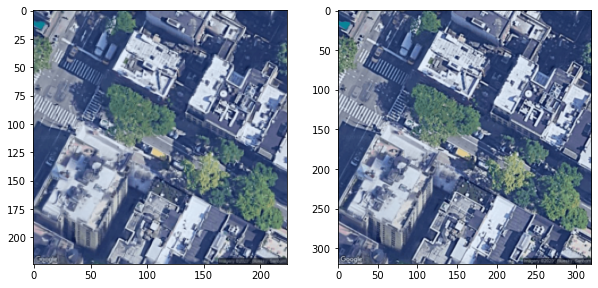

In [39]:
img1 = transform1(img_grd)
img2 = transform2(img_grd)
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(np.transpose(denormalize(img1.numpy()), (1,2,0)))
axes[1].imshow(np.transpose(denormalize(img2.numpy()), (1,2,0)))

plt.show()

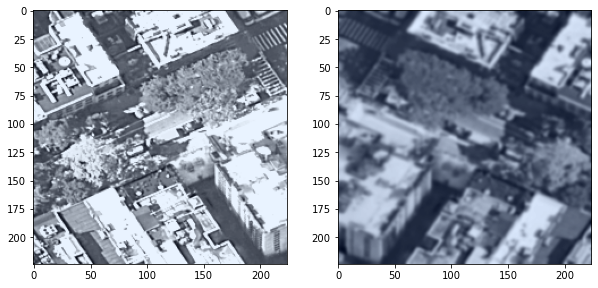

In [40]:
img3, img4 = transform3(img)

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(np.transpose(denormalize(img3.numpy()), (1,2,0)))
axes[1].imshow(np.transpose(denormalize(img4.numpy()), (1,2,0)))

plt.show()

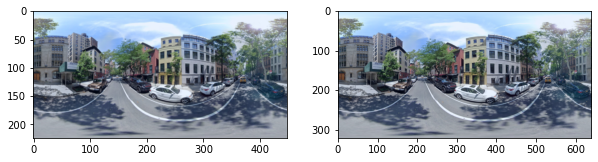

In [41]:
img5 = transform5(img_sat)
img6 = transform6(img_sat)
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(np.transpose(denormalize(img5.numpy()), (1,2,0)))
axes[1].imshow(np.transpose(denormalize(img6.numpy()), (1,2,0)))

plt.show()

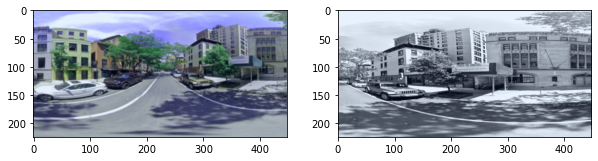

In [87]:
img7, img8 = transform4(img_sat)

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(np.transpose(denormalize(img7.numpy()), (1,2,0)))
axes[1].imshow(np.transpose(denormalize(img8.numpy()), (1,2,0)))

plt.show()

## Others

In [91]:
import datetime

def main(input):
    t0 = [int(x) for x in input.split('$')]
    t0 = datetime.date(year=t0[2], month=t0[0], day=t0[1])
    tdelta = datetime.timedelta(days=13)
    output = [t0 + i * tdelta for i in range(9)]
    output = [date.strftime('%m$%d$%Y') for date in output]
    return output

print(main('11$10$2016'))

['11$10$2016', '11$23$2016', '12$06$2016', '12$19$2016', '01$01$2017', '01$14$2017', '01$27$2017', '02$09$2017', '02$22$2017']
